# Recalibrating the ringdown attachment frequency for ENIGMA

 - The idea here is to use an MCMC algorithm to find the best parameters that make ENIGMA agree with SEOBNRv4 in the regions of parameter space that overlap for them
 - We will use the emcee package for this
 - We need a few components for MCMC:
    - A way to generate ENIGMA for a given set of parameters **$\theta$**
    - A FIT for $\omega_\mathrm{attach}$ as a function of $(q, M=m_1+m_2)$.
    - A FIT for PN order as a function of $(q, M)$


**Define**:
 1. $\alpha = \{a_1, a_2, a_3, \cdots\}$ that is a FIT for $\omega_\mathrm{attach}(\alpha)$
 1. $\theta = \{q, M, \omega_\mathrm{attach}(\alpha), \,\mathrm{PN\, order}\}$
 1. ndim = len($\theta$) = 4
 1. log_prob $\propto \langle h_1, h_2 \rangle$ 

**Choose internal parameters**:

 1. PSD $\in$ [**aLIGOZeroDetHighPower**, **Flat**]
 2. low frequency cutoff $\in [15, 20, 30]Hz$
 2. sample rate = $2048$
 2. masses $(m_1, m_2) \in [40, 60]M_\odot$
 2. attachment time $t_\mathrm{attach} \in $ **???**
 2. attachment time window $dt_\mathrm{attach} \in $ **???**

**Algorithm**:

* Sample $\theta$:
 1. $q \in [1,4]$
 1. $M \in [10, 100]M_\odot$
 1. PNO $\in [6, 7, 8, 9, 10, 11, 12]$
 1. $\omega_\mathrm{attach}(\alpha) \in [0.01, 0.1]$
* Do:
 1. Compute $h_1 \equiv$ h_ENIGMA$\left(\theta; t\right)$
 1. Compute $h_2 \equiv$ h_EOB$\left(\theta; t\right)$
 1. Compute log_prob = $\propto \langle h_1, h_2 \rangle$

**Code plan**:

* `gwnrtools_enigma_plan_grid_and_make_dag`
 - Inputs:
   - f_lower choices
   - psd choices
   - num_unique_mcmc_per_job
 - Meat:
   - Generate a hypercubic lattice over {f_lower, psd_choices}
   - 
 - Output:
   - DAG
* `gwnrtools_enigma_sample_parameters`
 - Inputs:
   - Fixed values of f_lower
   - Fixed values of psd
 - Meat:
   - Iterate over {f_lower, psd_choices}
   - MCMC over $\{m_1, m_2, \omega_\mathrm{attach}(\alpha), \mathrm{PNO}\}$ or $\{q, M, \omega_\mathrm{attach}(\alpha), \mathrm{PNO}\}$
 - Output:
   - Text file with columns:
     - [1] mass-ratio
     - [2] total-mass
     - [3] mass1
     - [4] mass2
     - [5] ecc value
     - [6] PN order
     - [7] omega_attach
     - [8] overlap
     - [9] Re[unphase-maximized overlap]
     - [10] Im[unphase-maximized overlap]
     - [11] norm1
     - [12] norm2

In [1]:
import os
import itertools
import logging
from multiprocessing import Pool
import numpy as np
import h5py
import emcee
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# PLOT STYLING
linestyles = ['-', '--', '-.', '-x', '--o']
linecolors = ['r', 'g', 'b', 'k', 'm', 'y']
gmean = (5**0.5 + 1)/2.

# Figure settings
ppi = 72.0
aspect = (5.**0.5 - 1) * 0.5
size = 4.0 * 3  # was 6
figsize = (size, aspect*size)
plt.rcParams.update({
    'legend.fontsize': 22,
    'axes.labelsize': 26,
    'font.family': 'serif',
    'font.size': 20,
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'figure.subplot.bottom': 0.2,
    'figure.figsize': figsize,
    'savefig.dpi': 300.0,
    'figure.autolayout': True})

In [3]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.psd import from_string
from pycbc.filter import match
import pycbc.pnutils as pnu
import lal

In [5]:
import gwnrtools
from gwnrtools.utils import make_padded_frequency_series
from gwnrtools.stats.samplers import get_emcee_ensemble_sampler
import pandas as pd

In [6]:
logging.getLogger().setLevel(logging.INFO)

In [7]:
run_directory = '/home/prayush/TESTME/run002/'

## `gwnrtools_enigma_plan_grid_and_make_dag`

**Code plan**:

* `gwnrtools_enigma_plan_grid_and_make_dag`
 - Inputs:
   - f_lower choices
   - psd choices
   - num_unique_mcmc_per_job
 - Meat:
   - Generate a hypercubic lattice over {f_lower, psd_choices}
   - 
 - Output:
   - DAG

In [215]:
# Make directories
dirs_to_make = ['input', 'results']

for d in dirs_to_make:
    if not os.path.exists(d):
        os.makedirs(d)


def job_id(job_num):
    return '{:06d}'.format(job_num)


def write_parameter_file(job_id, params):
    file_name = os.path.join('input/parameters_{0}.hdf'.format(job_id))
    if os.path.exists(file_name):
        return file_name
    with h5py.File(file_name) as fout:
        for param_name in params:
            fout.create_dataset(param_name, data=params[param_name])
    return file_name


def dag_file():
    return 'retune_enigma.dag'


def write_job_to_dag(job_id, param_file):
    with open(dag_file(), 'a+') as fout:
        fout.write('''\
JOB TUNE{0} sampler.submit
VARS TUNE{0} macrojobid="{0}"
VARS TUNE{0} macroparamfile="{1}"

'''.format(job_id, param_file))

In [216]:
# fake inputs
parameter_choices = {}

parameter_choices['mass1'] = np.arange(3., 100., 1.)
parameter_choices['mass2'] = np.arange(3., 100., 1.)
parameter_choices['f_lower'] = np.array([15., 30.])
parameter_choices['psd'] = ['aLIGOZeroDetHighPower']

In [218]:
parameters_to_grid_over = ['f_lower', 'psd']
num_unique_mcmc_per_job = 2

In [219]:
grid_choices = list(itertools.product(
    *[parameter_choices[p] for p in parameters_to_grid_over]))

* Make the grid

In [220]:
jobs = {}

num_mcmc_in_job = 1e9
job_num = 0
job_params = None

for p_vector in grid_choices:
    curr_p = {}
    for i, p in enumerate(parameters_to_grid_over):
        curr_p[p] = p_vector[i]

    if num_mcmc_in_job < num_unique_mcmc_per_job:
        # add to current job
        job_params.append(curr_p)

        num_mcmc_in_job += 1
        job_num += 1
    else:
        # close current job
        if job_params:
            jobs[curr_job_id] = job_params

        # start new job
        curr_job_id = job_id(job_num)
        job_params = [curr_p]

        num_mcmc_in_job = 1
        job_num += 1

# Leftover jobs
if job_params:
    jobs[curr_job_id] = job_params
    job_params = None

In [221]:
jobs

{'000000': [{'f_lower': 15.0, 'psd': 'aLIGOZeroDetHighPower'},
  {'f_lower': 30.0, 'psd': 'aLIGOZeroDetHighPower'}]}

In [222]:
# Move to run directory
if not os.path.exists(run_directory):
    os.makedirs(run_directory)
os.chdir(run_directory)

* Write submit file

In [16]:
submit_text = '''\
universe = vanilla
executable = scripts/gwnrtools_enigma_sample_parameters
arguments = " --job-id $(macrojobid) --parameter-file $(macroparamfile) "
accounting_group = ligo.dev.o3.cbc.explore.test
getenv = True
log = /usr1/prayush.kumar/tmpc8uHuQ
error = log/gwnrtools_enigma_sample_parameters-$(cluster)-$(process).err
output = log/gwnrtools_enigma_sample_parameters-$(cluster)-$(process).out
notification = never
queue 1
'''

In [18]:
with open("sampler.sub", "w") as fout:
    fout.write(submit_text)

* Design DAG
  * Iterate over the grid, and add a job for each!

In [223]:
for _job_id in jobs:
    job_params = jobs[_job_id]

    job_params_dict = {}

    for p in parameters_to_grid_over:
        job_params_dict[p] = [jp[p] for jp in job_params]

    parameter_file_name = write_parameter_file(_job_id, job_params_dict)
    write_job_to_dag(_job_id, parameter_file_name)

## `gwnrtools_enigma_sample_parameters`

**Code plan**

* `gwnrtools_enigma_sample_parameters`:
 - Inputs:
   - Parameter file
 - Meat:
   - Iterate over {f_lower, psd_choices}
   - MCMC over $\{m_1, m_2, \omega_\mathrm{attach}, \mathrm{PNO}\}$
 - Output:
   - Text file with columns:
     - [1] mass-ratio
     - [2] total-mass
     - [3] mass1
     - [4] mass2
     - [5] ecc value
     - [6] PN order
     - [7] omega_attach
     - [8] overlap
     - [9] Re[unphase-maximized overlap]
     - [10] Im[unphase-maximized overlap]
     - [11] norm1
     - [12] norm2

**Algorithm**

1. define a FIT function to get `omega_attach`:
   - as a product of polynomials
   - as a polynomial in multiple variables
1. add FIT parameters to the `sampling_params`
1. define loglikelihood function using this FIT
1. obtain sampler
1. SAMPLE AWAY!

 ### **Figure out a dilating mapping between inner-product / match, that is limited between 0 and 1, to a larger range**

(0.75, 1)

/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


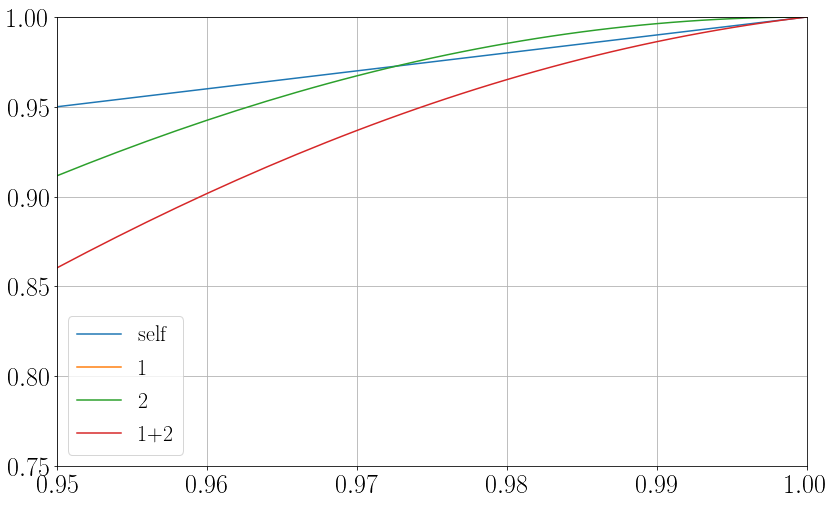

In [20]:
# FIGS
def obj1(m):
    return np.log(m)


def obj2(m):
    return np.sin(m*np.pi/2) ** 30


m = np.arange(0.01, 1.01, 0.001)
plt.plot(m, m, label='self')
plt.plot(m, obj1(m), label='1')
plt.plot(m, obj2(m), label='2')

plt.plot(m, obj1(m) + obj2(m), label='1+2')

plt.grid()
plt.legend()

plt.xlim(0.95, 1)
plt.ylim(0.75, 1)

### **Functions and Classes**

In [18]:
# Likelihood functions specific to this RUN
def log_prior_enigma(q, total_mass, PNO, coeffs, omega_attach,
                     sp_info,
                     omega_attach_lims=[0.01, 0.1]):
    '''
Priors:
-------

omega_attach : [0.01, 0.1]
PNO : [6, 7, 8, 9, 10, 11, 12]
    '''
    PNO = int(np.round(PNO))

    if np.any(coeffs < -1.) or np.any(coeffs > 1.):
        logging.info(
            "Rejecting coeffs={} from prior for coeffs".format(coeffs))
        return -np.inf

    if PNO not in sp_info.PNO.range:
        logging.info("Rejecting PNO={} from prior on PNO".format(PNO))
        return -np.inf

    if omega_attach < sp_info.omega_attach.range[0] or \
            omega_attach > sp_info.omega_attach.range[-1]:
        logging.info(
            "Rejecting MOmg={} from prior on omega_attach".format(omega_attach))
        return -np.inf

    if q < sp_info.q.range[0] or q > sp_info.q.range[1]:
        logging.info("Rejecting q={} from prior on q".format(q))
        return -np.inf

    if total_mass < sp_info.total_mass.range[0] or total_mass > sp_info.total_mass.range[1]:
        logging.info(
            "Rejecting M={} from prior on total_mass".format(total_mass))
        return -np.inf

    return 0.0


def log_likelihood_enigma(mass1, mass2, omega_attach, PNO, f_lower, sample_rate, psd):
    '''
This function takes in all parameters, including:
- masses
- omega_attach
- PN order

and computes the inner product between the sampled ENIGMA
waveform and an equivalent EOB waveform m = <h_1|h_2>.

Finally returns L = exp(-0.5 x m x m)
    '''
    # extract MCMC parameters
    PNO = int(np.round(PNO))

    # Use BASH MAGIC TO PASS MCMC parameters TO ENIGMA
    os.environ['OMEGA_ATTACH'] = '{0:.12f}'.format(omega_attach)
    os.environ['PN_ORDER'] = '{0:d}'.format(PNO)

    dt = 1. / sample_rate
    df = psd.delta_f
    N = int(sample_rate / psd.delta_f)

    # Generate ENIGMA wave
    try:
        h1p, h1c = get_td_waveform(approximant='ENIGMA',
                                   mass1=mass1,
                                   mass2=mass2,
                                   f_lower=f_lower,
                                   delta_t=dt)
    except:
        print("Could not generate ENIGMA wave..m1={},m2={},omg={},PNO={}".format(
            mass1, mass2, omega_attach, PNO))
        return -np.inf
    h1p = make_padded_frequency_series(h1p, N, df)
    #h1c = make_padded_frequency_series(h1c, N, df)

    # Generate EOB wave
    try:
        h2p, h2c = get_fd_waveform(approximant='SEOBNRv4_ROM',
                                   mass1=mass1,
                                   mass2=mass2,
                                   f_lower=f_lower,
                                   delta_f=df)
    except:
        print("Could not generate EOB wave..")
        return -np.inf
    h2p = make_padded_frequency_series(h2p, N, df)
    #h2c = make_padded_frequency_series(h2c, N, df)

    # Undo BASH MAGIC TO PASS MCMC parameters TO ENIGMA
    os.environ['OMEGA_ATTACH'] = ''
    os.environ['PN_ORDER'] = ''

    # Compute inner prodcut
    log_like, _ = match(h1p, h2p, psd=psd, low_frequency_cutoff=f_lower)
    return log_like


def log_prob(theta, inputs, f_lower, sampling_params, psd):
    '''
    Inputs:
    -------

    theta: (11) mass1, mass2, PNO, a1, a2, a3, a4, b1, b2, b3, b4
           (11)     q, mtotal,PNO, a1, a2, a3, a4, b1, b2, b3, b4
           (11)   eta, mtotal,PNO, a1, a2, a3, a4, b1, b2, b3, b4
    inputs: pandas.core.series.Series
            Attributes should include ('f_lower', 'sample_rate')
    psd: pycbc.FrequencySeries

    '''
    # Ordering is enforced here
    q, total_mass, PNO = theta[:3]
    coeffs = theta[3:]

    eta = q / (1. + q)**2
    mass1, mass2 = pnu.mtotal_eta_to_mass1_mass2(total_mass, eta)
    #q = mass1 / mass2
    #total_mass = mass1 + mass2

    # Evaluate attachment freq from coefficients a1-a4 and b2-b4
    fit = FitMOmegaIMRAttachmentNonSpinning()
    m_omega_attach = fit.fit_ratio_poly_44(eta, coeffs)
    #omega_attach = m_omega_attach / (total_mass * lal.MTSUN_SI)

    # prior probability
    log_prior = log_prior_enigma(
        q, total_mass, PNO, coeffs, m_omega_attach, sampling_params)
    if not np.isfinite(log_prior):
        return log_prior

    # posterior = likelihood x prior
    return log_likelihood_enigma(mass1, mass2, m_omega_attach, PNO,
                                 f_lower,
                                 inputs.sample_rate, psd) + log_prior


__order_of_sampled_params__ = ['q', 'total_mass',
                               'PNO', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4']

In [66]:
# Functions to format sampler output and write to disk
def output_file(prefix, job_id, idx):
    return prefix + '{0}_{1:06d}.dat'.format(job_id, idx)

In [16]:
class FitMOmegaIMRAttachmentNonSpinning():
    def __init__(self):
        return

    @staticmethod
    def fit_quadratic_poly(eta, coeffs):
        assert (len(coeffs) == 3), "{} coeffs passed!".format(len(coeffs))
        a1, a2, a3 = coeffs
        return a1 + a2 * eta + a3 * eta * eta

    @staticmethod
    def fit_cubic_poly(eta, coeffs):
        assert (len(coeffs) == 4), "{} coeffs passed!".format(len(coeffs))
        a1, a2, a3, a4 = coeffs
        return a1 + a2 * eta + a3 * eta * eta + a4 * eta * eta * eta

    @staticmethod
    def fit_ratio_poly_44(eta, coeffs):
        assert (len(coeffs) == 7), "{} coeffs passed!".format(len(coeffs))
        a1, a2, a3, a4, b2, b3, b4 = coeffs
        return (a1 + a2 * eta + a3 * eta * eta + a4 * eta * eta * eta) / (1. + b2 * eta + b3 * eta * eta + b4 * eta * eta * eta)

    @staticmethod
    def fit_ratio_poly_43(eta, coeffs):
        assert (len(coeffs) == 6), "{} coeffs passed!".format(len(coeffs))
        a1, a2, a3, a4, b2, b3 = coeffs
        return (a1 + a2 * eta + a3 * eta * eta + a4 * eta * eta * eta) / (1. + b2 * eta + b3 * eta * eta)

    @staticmethod
    def fit_ratio_poly_34(eta, coeffs):
        assert (len(coeffs) == 6), "{} coeffs passed!".format(len(coeffs))
        a1, a2, a3, b2, b3, b4 = coeffs
        return (a1 + a2 * eta + a3 * eta * eta) / (1. + b2 * eta + b3 * eta * eta + b4 * eta * eta * eta)

### **Capture inputs**

In [9]:
os.chdir(run_directory)

In [76]:
# Fake inputs
inputs = {}

inputs['job_id'] = '006000'
inputs['param_file'] = 'input/parameters_000000.hdf'
inputs['signal_approx'] = 'SEOBNRv4_ROM'
inputs['output_prefix'] = 'results/matches_vs_' + \
    '{0}'.format(inputs['signal_approx'])

inputs['num_samplers'] = 4
inputs['num_steps'] = 5
#limits_omega_attach = [0.01, 0.1]
#choices_PNO = [6, 7, 8, 9, 10, 11, 12]

inputs['sample_rate'] = 4096
inputs['time_length'] = 32
#inputs['f_lower']     = 15.
#inputs['psd']         = 'aLIGOZeroDetHighPower'

In [77]:
inputs['delta_t'] = 1. / inputs['sample_rate']
inputs['delta_f'] = 1. / inputs['time_length']
N = inputs['sample_rate'] * inputs['time_length']
n = N / 2 + 1

In [12]:
inputs['fixed_params'] = (['f_lower', 'psd'],)

In [80]:
with h5py.File(inputs['param_file'], 'r') as fin:
    inputs['fixed_params'] = (list(fin.keys()),)
    for k in fin:
        inputs[k] = [fin[k][()], ]

In [82]:
inputs = pd.DataFrame.from_dict(inputs)

In [83]:
inputs

,delta_f,delta_t,f_lower,fixed_params,job_id,num_samplers,num_steps,output_prefix,param_file,psd,sample_rate,signal_approx,time_length
0,0.03125,0.000244,"[15.0, 30.0]","[f_lower, psd]",006000,4,5,results/matches_vs_SEOBNRv4_ROM,input/parameters_000000.hdf,"[aLIGOZeroDetHighPower, aLIGOZeroDetHighPower]",4096,SEOBNRv4_ROM,32


In [89]:
print("test {0}, {1}".format(*sampling_params.PNO.range))

test 6, 7


### **Define sampled parameters and their limits, etc**

In [17]:
parameters_to_sample = {}

parameters_to_sample['q'] = ('continuous', [1., 4.])
parameters_to_sample['total_mass'] = ('continuous', [10., 100.])
parameters_to_sample['omega_attach'] = ('continuous', [0.01, 0.1])
parameters_to_sample['PNO'] = ('discrete', [6, 7, 8, 9, 10, 11, 12])

sampling_params = pd.DataFrame.from_dict(parameters_to_sample)
sampling_params = sampling_params.set_index(pd.Index(['vartype', 'range']))

sampling_params['a1'] = ('continuous', [-1., 1.])
sampling_params['a2'] = ('continuous', [-1., 1.])
sampling_params['a3'] = ('continuous', [-1., 1.])
sampling_params['a4'] = ('continuous', [-1., 1.])

sampling_params['b2'] = ('continuous', [-1., 1.])
sampling_params['b3'] = ('continuous', [-1., 1.])
sampling_params['b4'] = ('continuous', [-1., 1.])

In [19]:
sampling_params['sampler_params'] = ('discrete', __order_of_sampled_params__)
inputs['sampler_params'] = (__order_of_sampled_params__,)

In [21]:
sampling_params

,PNO,omega_attach,q,total_mass,a1,a2,a3,a4,b2,b3,b4,sampler_params
vartype,discrete,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,discrete
range,"[6, 7, 8, 9, 10, 11, 12]","[0.01, 0.1]","[1.0, 4.0]","[10.0, 100.0]","[-1.0, 1.0]","[-1.0, 1.0]","[-1.0, 1.0]","[-1.0, 1.0]","[-1.0, 1.0]","[-1.0, 1.0]","[-1.0, 1.0]","[q, total_mass, PNO, a1, a2, a3, a4, b2, b3, b4]"


In [22]:
inputs

,delta_f,delta_t,fixed_params,job_id,num_samplers,num_steps,output_prefix,param_file,sample_rate,signal_approx,time_length,f_lower,psd,sampler_params
0,0.03125,0.000244,"[f_lower, psd]",006000,4,5,results/matches_vs_SEOBNRv4_ROM,input/parameters_000000.hdf,4096,SEOBNRv4_ROM,32,"[15.0, 30.0]","[aLIGOZeroDetHighPower, aLIGOZeroDetHighPower]","(q, total_mass, PNO, a1, a2, a3, a4, b2, b3, b4)"


### **Main workflow**

In [110]:
my_pool = Pool(processes=4)

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
('  params:', array([12.        , 17.80102977, 30.68035528, -0.29656878,  0.82767188,
       -0.13887474, -0.6893571 , -0.28366922, -0.28601534,  0.2630973 ]))
('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef6518910>])
emcee: Exception while calling your likelihood function:
('  params:', array([ 6.        , 21.89102461, 32.5881864 , -0.97860875, -0.798703  ,
       -0.16868457,  0.81537724,  0.93255531, -0.94477185, -0.10590953]))
emcee: Exception while calling your likelihood function:
('  kwargs:', {})
('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef6518490>])
  exception:
('  params:', array([10.        , 17.7156704 , 39.49016151, -0.74188033, -0.32316512,
        0.79555081,  0.33576872, -0.59353897, -0.64475823, -0.32920041]))

Traceback (most recent call last):


('  kwargs:', {})

  exception:
('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef6518550>])


Traceback (most recent call last):


('  kwargs:', {})


  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


  exception:
('  params:', array([12.        , 37.59241919, 19.83267039, -0.51510186,  0.94538707,
        0.98816598,  0.76275108, -0.2185934 ,  0.40931709,  0.09544879]))

Traceback (most recent call last):


  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65187d0>])


    return self.f(x, *self.args, **self.kwargs)


('  kwargs:', {})


    return self.f(x, *self.args, **self.kwargs)
  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob


  exception:


Traceback (most recent call last):
    return self.f(x, *self.args, **self.kwargs)
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
ValueError: need more than 10 values to unpack
  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
ValueError: need more than 10 values to unpack
ValueError: need more than 10 values to unpack
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
ValueError: need more than 10 values to unpack


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
('  params:', array([ 9.        , 32.5523115 , 23.40409519, -0.79917496,  0.85358452,
        0.72301896, -0.26147264, -0.54459516,  0.84226936,  0.53704442]))('  params:', array([ 8.        , 10.87428111, 11.33996355,  0.10424813, -0.42380849,
        0.33144801,  0.71400869, -0.59126083,  0.69559532, -0.90662104]))
emcee: Exception while calling your likelihood function:

emcee: Exception while calling your likelihood function:
('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65bb950>])
('  kwargs:', {})
('  params:', array([ 6.        , 34.55324106, 35.16302648, -0.73760011, -0.55846286,
       -0.34807251,  0.40306189, -0.6818301 ,  0.16584095,  0.96621574]))('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65bb950>])
  exception:
('  kwargs:', {})


Traceback (most recent call last):


  exception:


  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta


    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob


('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65bb950>])


    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta


('  kwargs:', {})


ValueError: need more than 10 values to unpack
ValueError: need more than 10 values to unpack


('  params:', array([ 8.        , 23.28063626, 27.33606118, -0.18222143, -0.97782716,
        0.49972466, -0.36389249, -0.05194974, -0.43738268, -0.24789061]))emcee: Exception while calling your likelihood function:
  exception:
emcee: Exception while calling your likelihood function:
('  params:', array([ 8.        , 33.07899446, 34.39585342,  0.35705561,  0.91422828,
        0.11080151,  0.48500502, -0.9216886 ,  0.20587518,  0.12254118]))

Traceback (most recent call last):
  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__




('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65187d0>])
('  kwargs:', {})
('  params:', array([ 9.        , 34.88761671, 13.95867723, -0.96846959,  0.68867051,
        0.208798  , -0.68580368, -0.07797198,  0.9721266 , -0.63921091]))('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65bb950>])
  exception:



Traceback (most recent call last):


('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef6518490>])
('  kwargs:', {})


    return self.f(x, *self.args, **self.kwargs)


  exception:


  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  kwargs:', {})


Traceback (most recent call last):


  exception:


  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
ValueError: need more than 10 values to unpack
ValueError: need more than 10 values to unpack
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
Traceback (most recent call last):


emcee: Exception while calling your likelihood function:


  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
ValueError: need more than 10 values to unpack


('  params:', array([ 8.        , 27.03124781, 18.79772505, -0.22731719, -0.7893958 ,
       -0.85614772,  0.18815203,  0.40673148,  0.41754016,  0.33958834]))emcee: Exception while calling your likelihood function:



    return self.f(x, *self.args, **self.kwargs)


('  params:', array([11.        , 26.72957251, 15.05105288, -0.07281584, -0.84635583,
       -0.21002985, -0.8340486 , -0.2685277 , -0.71788638,  0.37067095]))emcee: Exception while calling your likelihood function:
('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65bb950>])


  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob


    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta


('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef6518550>])
('  params:', array([10.        , 16.7447174 , 31.14689538, -0.69954496, -0.74053359,
       -0.420444  ,  0.81968325,  0.9720914 ,  0.30711808,  0.3799269 ]))

ValueError: need more than 10 values to unpack


('  kwargs:', {})
  exception:



Traceback (most recent call last):


('  kwargs:', {})
('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65bb950>])


  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  kwargs:', {})
  exception:
  exception:


    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)
ValueError: need more than 10 values to unpack
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob
  File "<ipython-input-105-335ae40144d6>", line 93, in log_prob


emcee: Exception while calling your likelihood function:


    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta
    q, total_mass, PNO, a1, a2, a3, a4, b1, b2, b3, b4 = theta


('  params:', array([ 9.        , 15.11017415, 15.08712367, -0.47336972, -0.72748312,
        0.35111264, -0.4097081 ,  0.62100102,  0.48152291, -0.56121853]))emcee: Exception while calling your likelihood function:


ValueError: need more than 10 values to unpack


('  params:', array([ 8.        , 21.51691268, 13.06027487,  0.96257492, -0.44726737,
        0.66600334, -0.25329669,  0.09311853,  0.47861969, -0.84601716]))
emcee: Exception while calling your likelihood function:


ValueError: need more than 10 values to unpack



('  args:', [15.0, 4096.0, <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbef65bb950>

limit_output extension: Maximum message size of 10000 exceeded with 10003 characters

In [29]:
num_samplers = 64

In [26]:
os.environ['LAL_DATA_PATH']

'/media/prayush/Data/research/ROM_data/'

In [30]:
samplers = {}

num_steps = 1000
job_id = 11

# Loop over all unique MCMC jobs
for idx in range(len(inputs[inputs.fixed_params[0][0]][0])):
    if True:
        #mass1 = inputs['mass1'][idx]
        #mass2 = inputs['mass2'][idx]
        f_lower = inputs['f_lower'][0][idx]
        df = inputs['delta_f'][0]
        dt = inputs['delta_t'][0]
        sample_rate = 1. / dt
        N = int(1. / dt / df)
        n = N / 2 + 1

        psd = from_string(inputs['psd'][0][idx], n, df, f_lower)
        psd = make_padded_frequency_series(psd, N, df)

        # RUN THE SAMPLER
        logging.warn("Initializing the MCMC sampler and burning-in")
        samplers[idx] = get_emcee_ensemble_sampler(log_prob,
                                                   sampling_params[sampling_params['sampler_params'].range],
                                                   [inputs.iloc[0],
                                                       f_lower, sampling_params, psd],
                                                   nwalkers=num_samplers,
                                                   pool=None)

        logging.warn(
            "Running the MCMC sampler for {0} steps".format(num_steps))
        s, state = samplers[idx]
        s.run_mcmc(state, num_steps)

        # WRite output from the sampler
        write_output_from_sampler(output_file(inputs['output_prefix'][0],
                                              job_id,
                                              idx),
                                  s, sampling_params[sampling_params['sampler_params'].range])

        # Early stop
        if idx >= 0:
            break
    else:
        logging.warn(
            "Error in parameter set[{0}]:f_low={1:.0f}".format(idx, f_lower))
        raise

Initializing sampler WITH initial state check
Rejecting MOmg=-0.846209863177 from prior on omega_attach
Rejecting MOmg=0.60983933133 from prior on omega_attach
Rejecting MOmg=0.802043196093 from prior on omega_attach
Rejecting MOmg=-0.177219577498 from prior on omega_attach
Rejecting MOmg=-0.760902264202 from prior on omega_attach
Rejecting MOmg=-0.20050136856 from prior on omega_attach
Rejecting MOmg=0.588094578191 from prior on omega_attach
Rejecting MOmg=0.522175194225 from prior on omega_attach
Rejecting MOmg=0.929682175735 from prior on omega_attach
Rejecting MOmg=0.103413640423 from prior on omega_attach
Rejecting MOmg=-0.895332692371 from prior on omega_attach
Rejecting MOmg=-0.940398938087 from prior on omega_attach
Rejecting MOmg=-0.0524172246656 from prior on omega_attach
Rejecting MOmg=0.583017607425 from prior on omega_attach
Rejecting MOmg=0.702612282944 from prior on omega_attach
Rejecting MOmg=0.459931994751 from prior on omega_attach
Rejecting MOmg=0.962886761018 from p

limit_output extension: Maximum message size of 10000 exceeded with 20531 characters

### **Visualize sampler output**

In [112]:
finite_logl_mask = np.isfinite(s.get_log_prob())
full_post = s.get_chain()
finite_logl_post = {}
for nchain in range(full_post.shape[-1]):
    finite_logl_post[__order_of_sampled_params__[nchain]
                     ] = full_post[..., nchain][finite_logl_mask]
finite_logl_post['log_prob'] = s.get_log_prob()[finite_logl_mask]
finite_logl_post = pd.DataFrame.from_dict(finite_logl_post)
finite_logl_post = finite_logl_post.rename(
    columns={c: c.replace('_', '-') for c in finite_logl_post.columns})

In [113]:
finite_logl_post

,PNO,a1,a2,a3,a4,b2,b3,b4,log-prob,q,total-mass
0,8.363518,-0.062138,0.670173,-0.155430,0.792582,0.263653,0.765009,-0.457434,0.916241,2.733885,27.540249
1,7.344456,-0.144094,0.619046,0.606611,0.722956,0.390304,-0.600231,-0.070565,0.994461,2.147540,69.490414
2,7.814074,-0.035912,0.464826,0.217888,0.075316,-0.660064,-0.241471,0.101899,0.985743,1.876144,43.113152
3,7.266772,0.068183,-0.104374,0.605158,0.299343,0.368197,-0.010057,-0.171645,0.767399,3.568032,33.048673
4,8.616993,0.004183,0.371692,0.273777,-0.028495,-0.496584,-0.142572,-0.019790,0.874199,2.690535,26.193750
5,8.867872,0.142490,-0.801114,0.770203,0.244581,-0.125765,-0.900087,-0.428476,0.128858,2.839809,8.364579
6,10.183263,0.055009,-0.154505,0.177962,0.993177,-0.329047,0.293551,0.074953,0.997265,3.892619,56.681189
7,11.153044,0.243159,-0.710573,-0.174463,-0.022282,-0.930462,0.182479,-0.468515,0.779243,0.991612,28.888642
8,5.812178,-0.036121,0.878539,-0.544660,-0.789762,0.552790,0.669656,-0.778157,0.713321,2.801943,40.157481
9,8.504857,0.157667,-0.624273,-0.402294,-0.775335,0.043099,-0.553912,-0.914502,0.996172,3.465913,76.118273


limit_output extension: Maximum message size of 10000 exceeded with 19317 characters

In [116]:
g.map_lower?

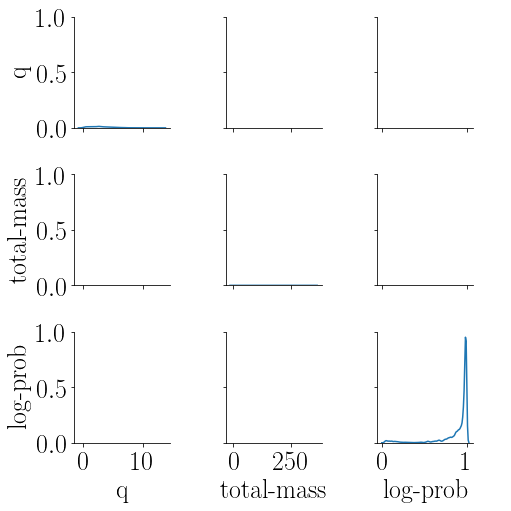

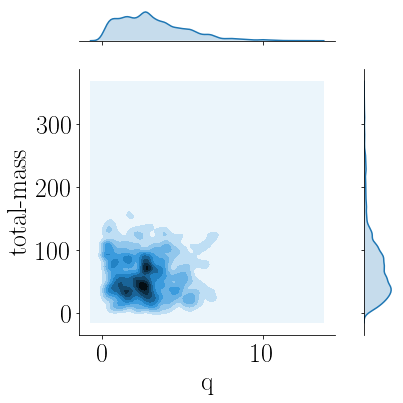

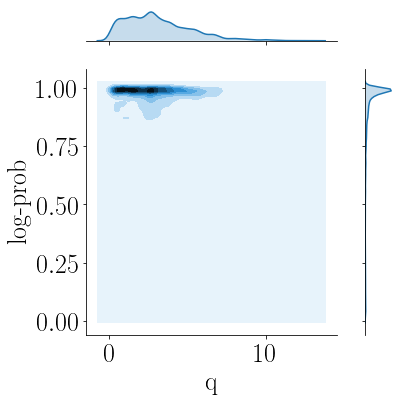

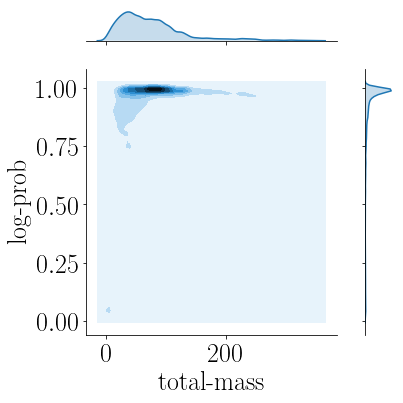

In [117]:
g = sns.PairGrid(finite_logl_post[['q', 'total-mass', 'log-prob']])
g.map_lower(sns.jointplot, kind='kde')
g.map_diag(sns.kdeplot)

### Visualize output posterior

In [33]:
dd = np.loadtxt('results/matches_vs_SEOBNRv4_ROM11_000000.dat')

In [54]:
post = pd.DataFrame(dd.T, columns=[x.replace('_', '-') for x in __order_of_sampled_params__])

In [46]:
import seaborn as sns

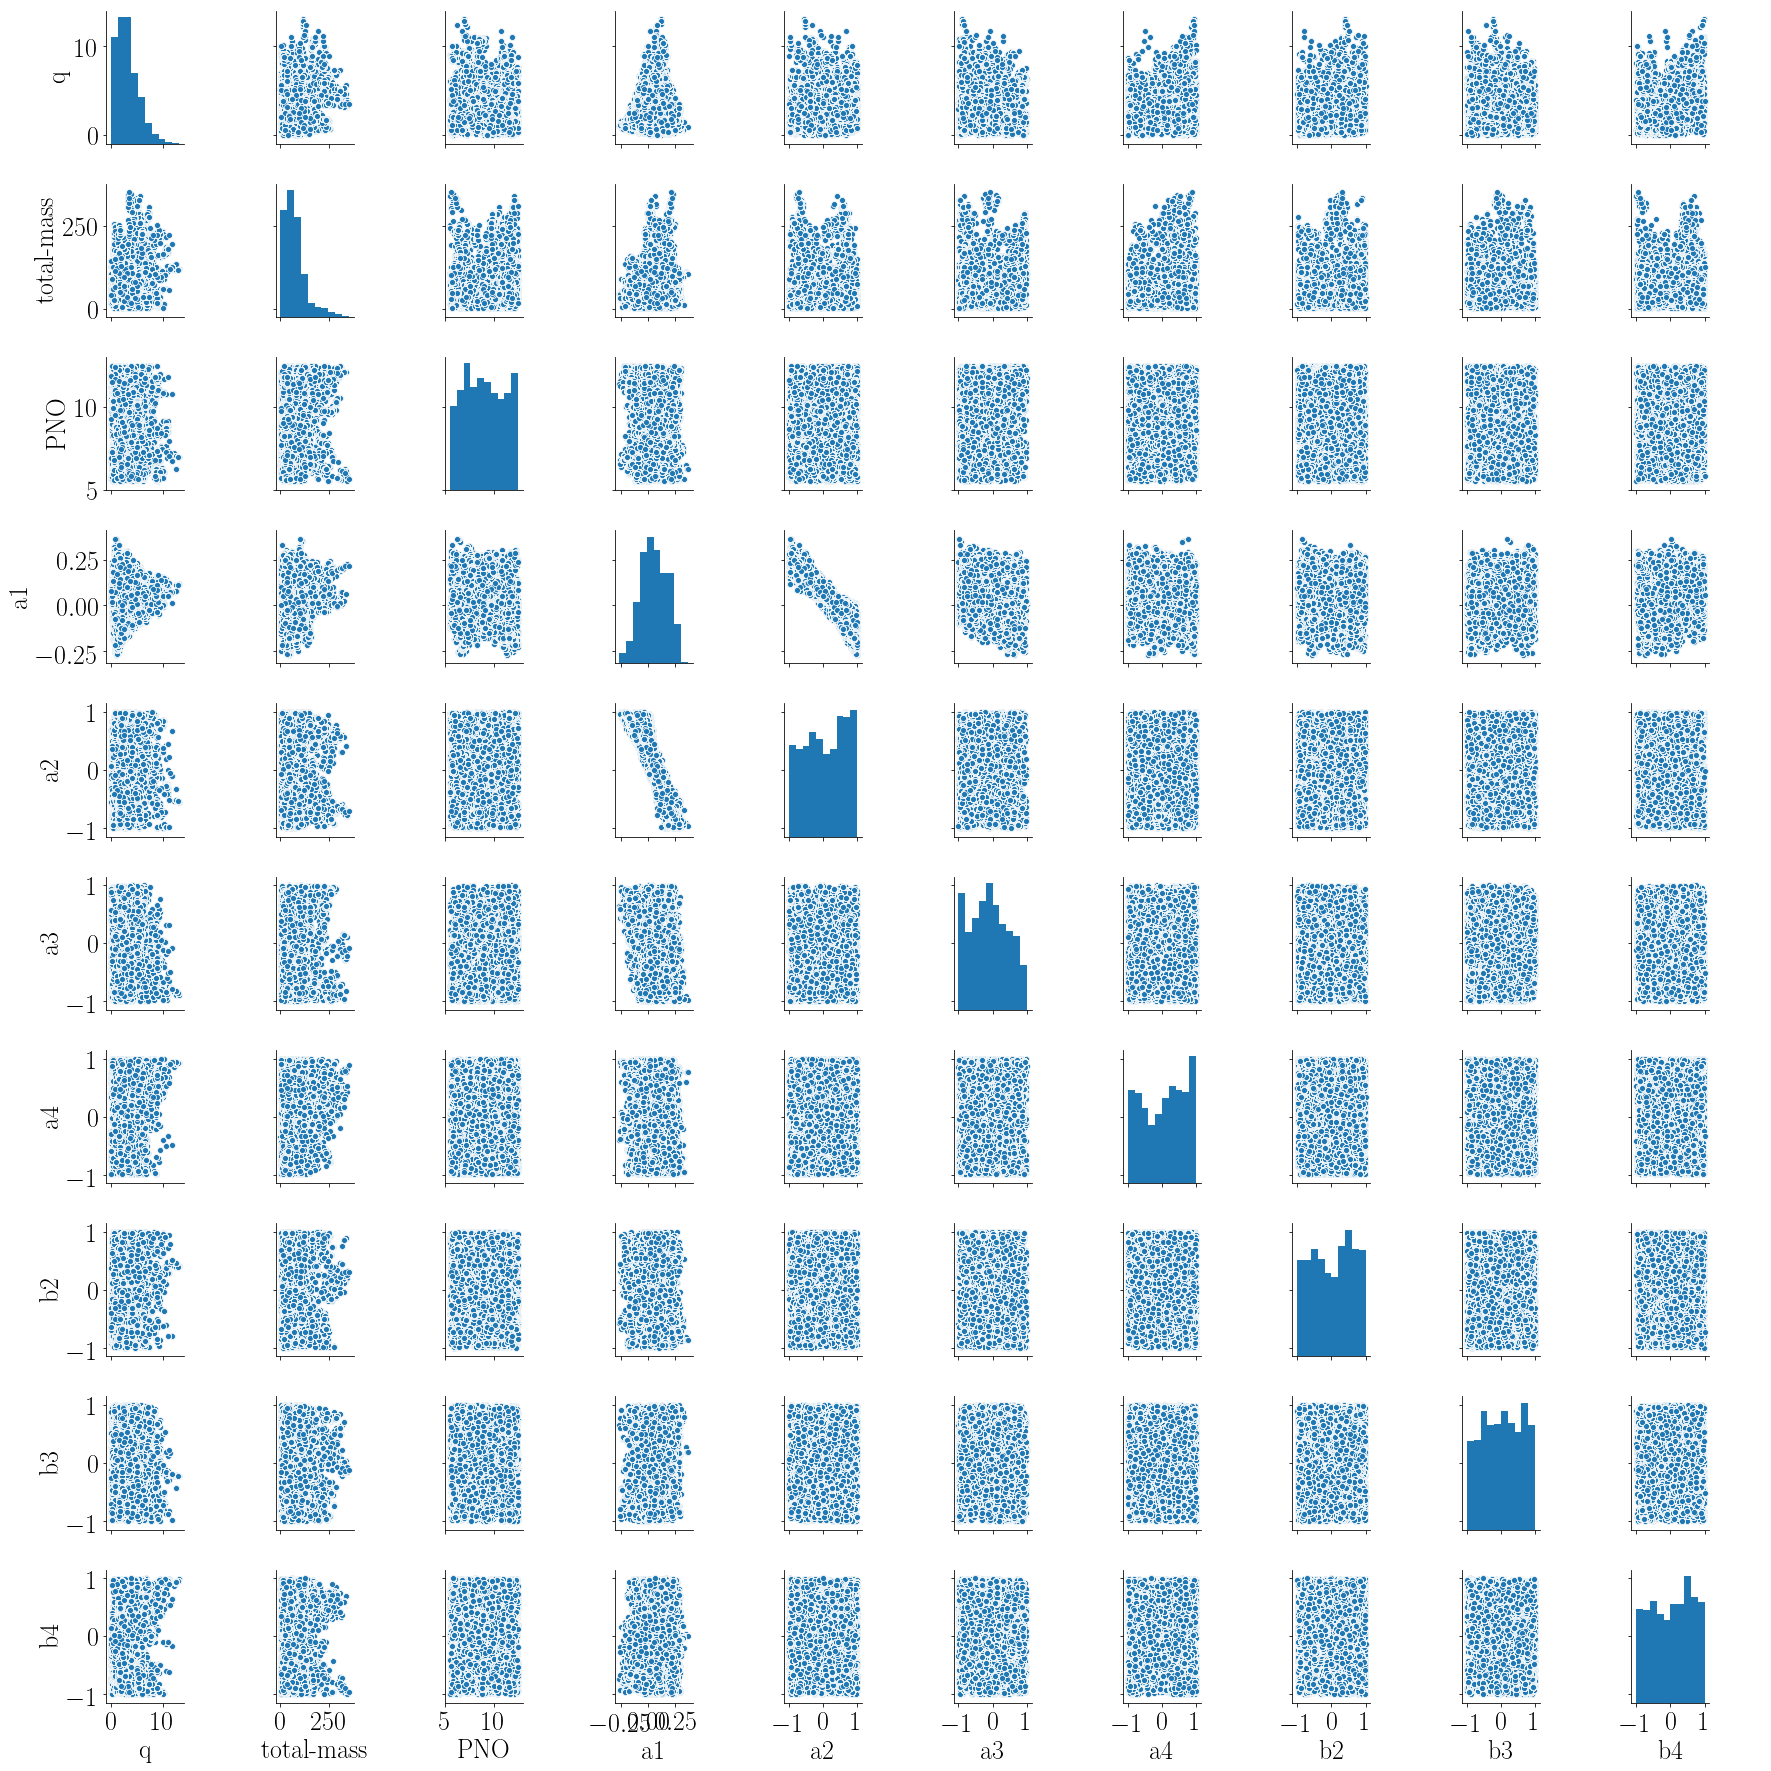

In [55]:
sns.pairplot(post)

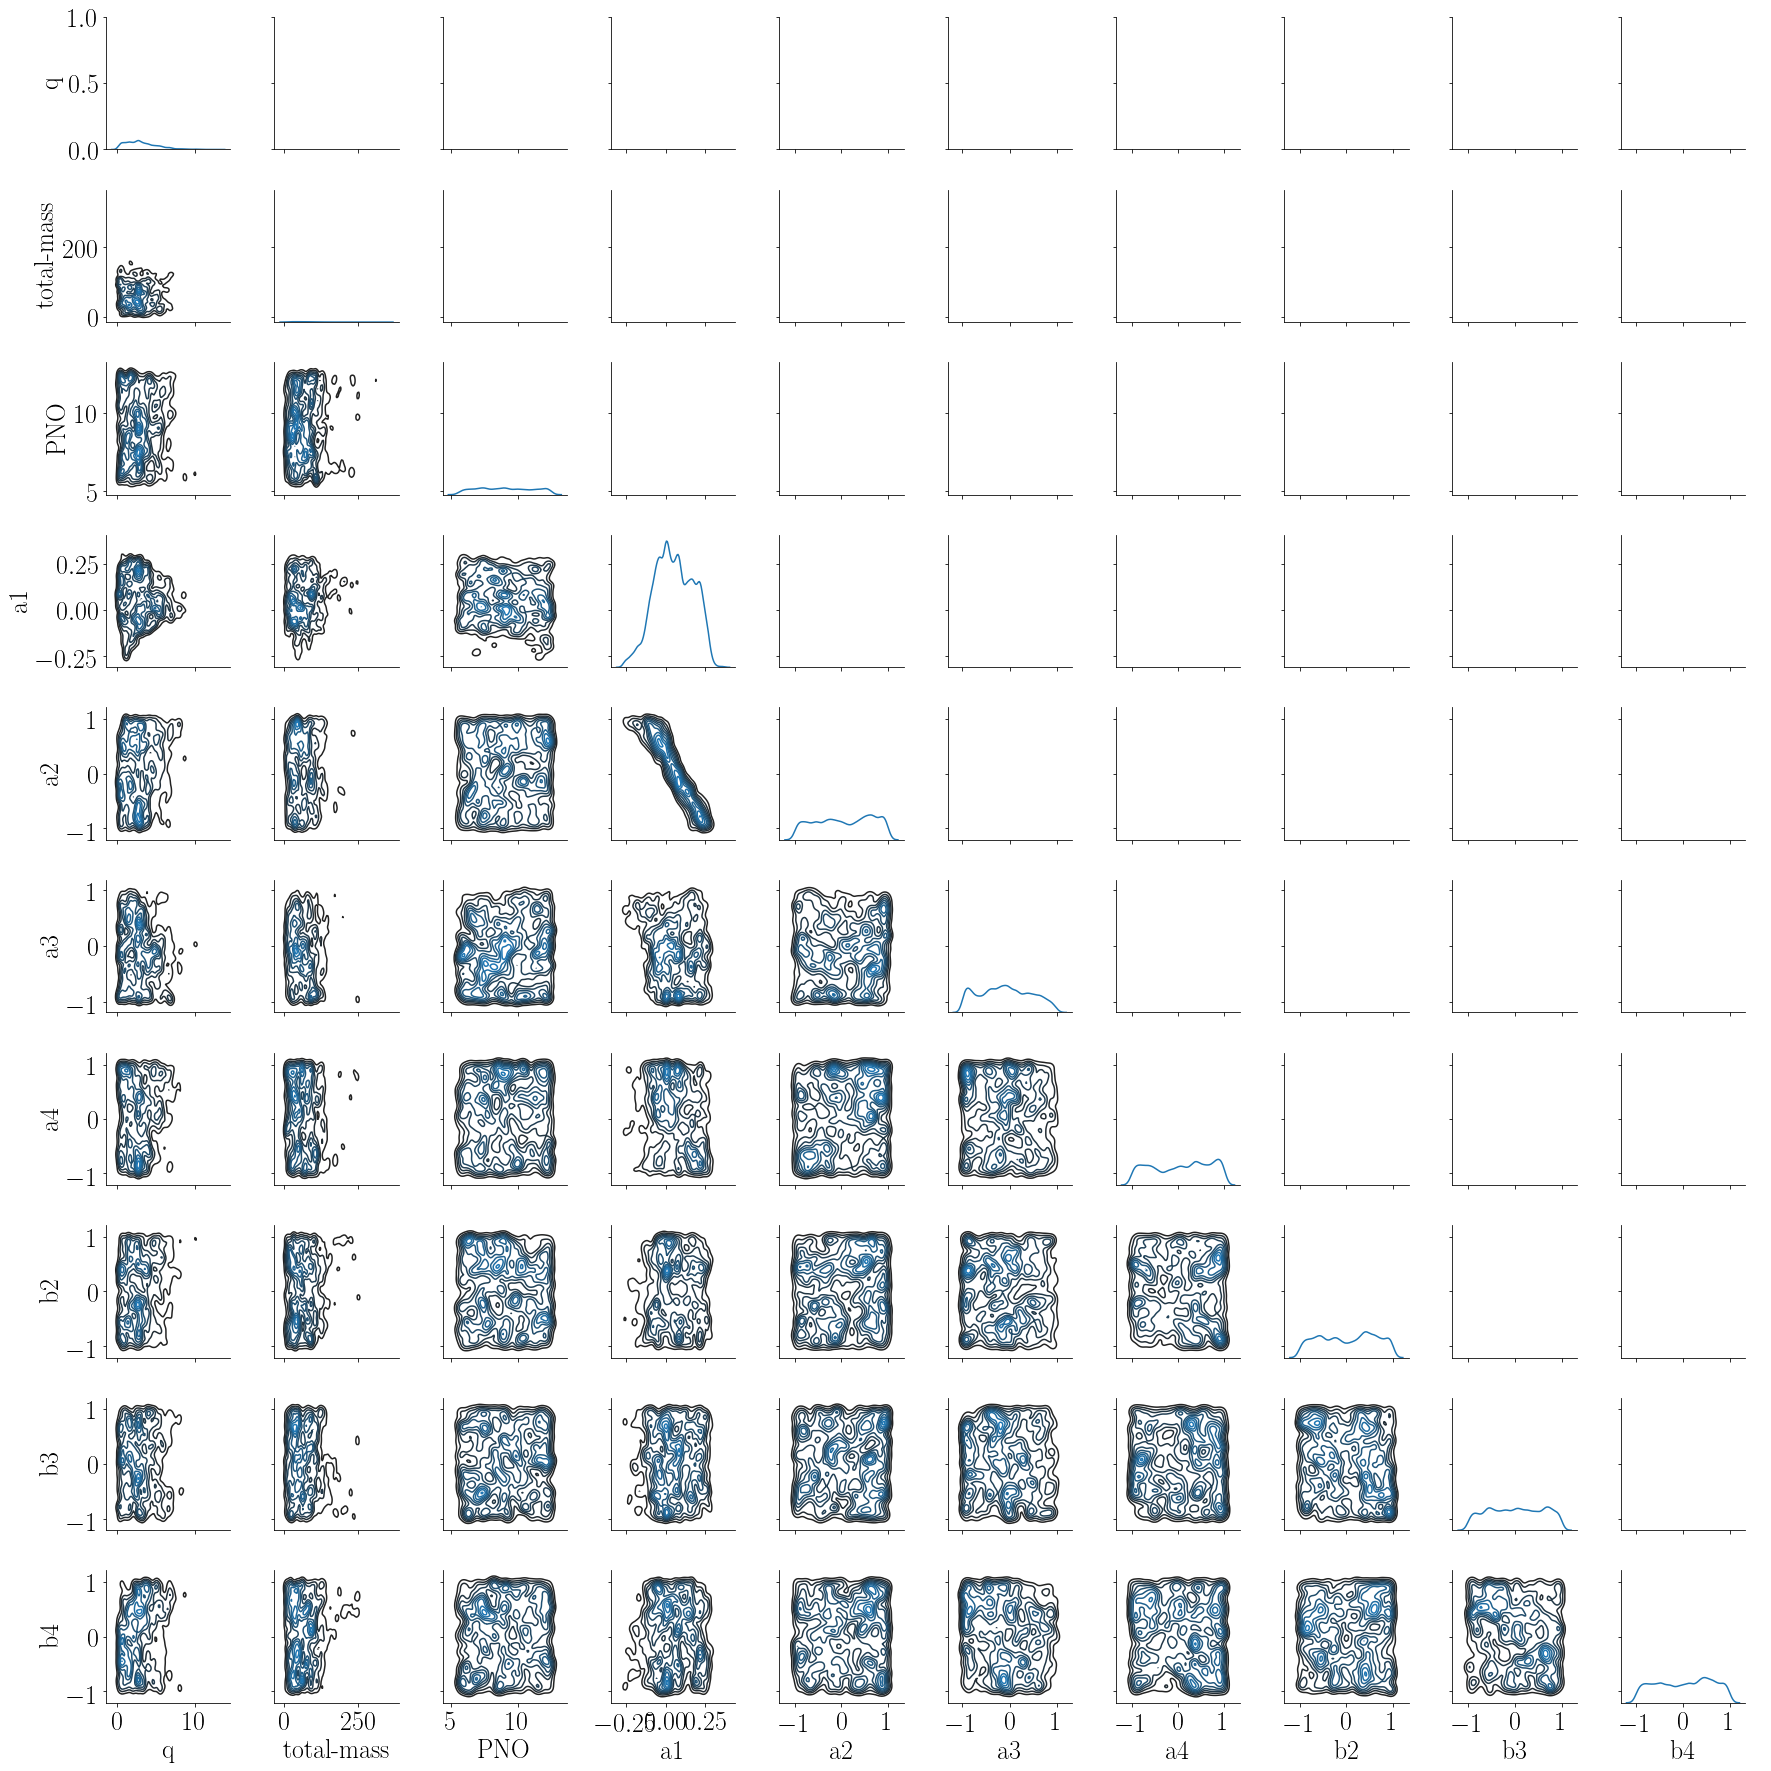

In [60]:
g = sns.PairGrid(post)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

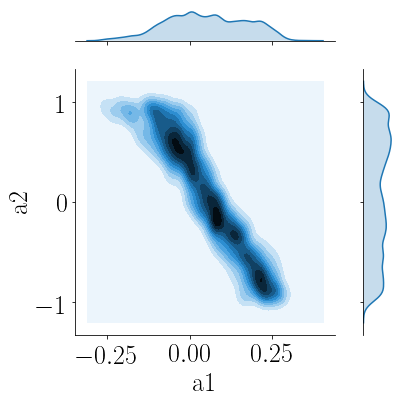

In [59]:
sns.jointplot('a1', 'a2', post, kind='kde')

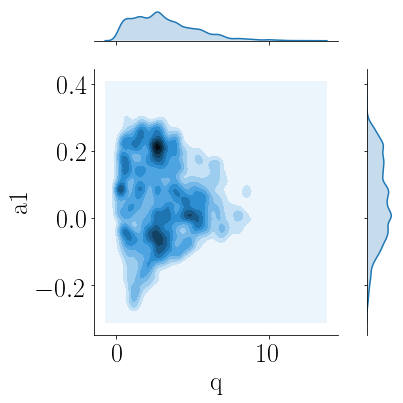

In [61]:
sns.jointplot('q', 'a1', post, kind='kde')

In [72]:
lp.flatten()[0]

-inf

In [74]:
lpfinite = lp.flatten()[np.where(np.isfinite(lp.flatten()))[0]]

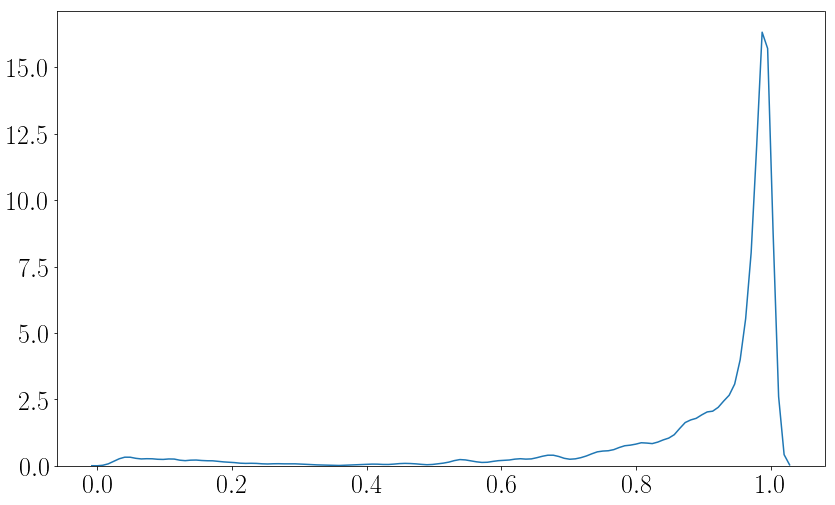

In [75]:
sns.kdeplot(lpfinite)

In [65]:
s, state = samplers[0]

In [38]:
state2 = s.run_mcmc(state, 100)

ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampl

ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampl

ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..
ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


ERROR:root:Could not generate ENIGMA wave..


YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...
YAY: sampling within prior...


In [113]:
pno_samples = s.chain[:, :, 1].T
omega_attach_samples = s.chain[:, :, 0].T
match_samples = s.get_log_prob()

assert(np.shape(pno_samples) == np.shape(omega_attach_samples))
assert(np.shape(pno_samples) == np.shape(match_samples))

pno_samples = pno_samples.flatten()
omega_attach_samples = omega_attach_samples.flatten()
match_samples = match_samples.flatten()

notfailed = match_samples.flatten() != 0

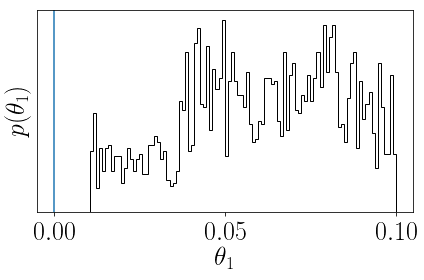

In [98]:
samples = s.get_chain(flat=True)
plt.axvline(0)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([])

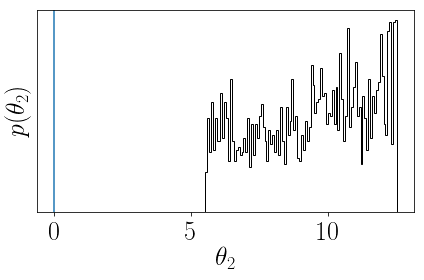

In [100]:
samples = s.get_chain(flat=True)
plt.axvline(0)
plt.hist(samples[:, 1], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$p(\theta_2)$")
plt.gca().set_yticks([])

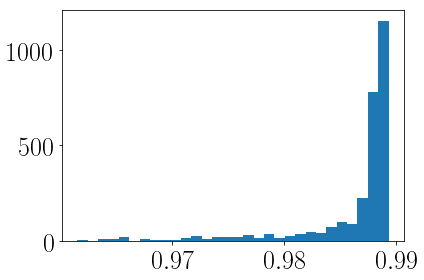

In [115]:
_ = plt.hist(match_samples[notfailed], bins=30)

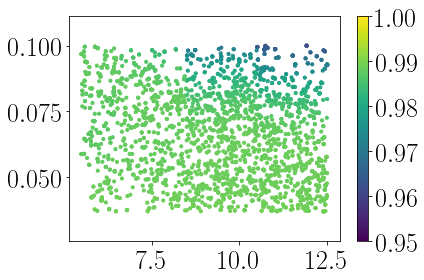

In [116]:
plt.scatter(pno_samples[notfailed], omega_attach_samples[notfailed],
            c=match_samples[notfailed],
            s=10,
            vmin=0.95,
            vmax=1.0)
plt.colorbar()

### Check diagnostics

In [102]:
print("Mean acceptance fraction: {0:.3f}".format(
    np.mean(s.acceptance_fraction)))

Mean acceptance fraction: 0.604


In [103]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(s.get_autocorr_time())
    )
)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [8.79738672 8.46783494]